In [3]:
import os
from pathlib import Path
from PIL import Image
from sklearn.model_selection import KFold

data_path = Path("food")


# Setup train and testing paths
train_dir = data_path / "train"
test_dir = data_path / "test"
pred_dir = data_path / "prediction"


def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  """
  for dirpath, dirnames, filenames in os.walk(data_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(train_dir)
print("____________________________________________________")
walk_through_dir(test_dir)

There are 3 directories and 0 images in 'food'.
There are 3 directories and 0 images in 'food\prediction'.
There are 0 directories and 15 images in 'food\prediction\pizza'.
There are 0 directories and 15 images in 'food\prediction\steak'.
There are 0 directories and 15 images in 'food\prediction\sushi'.
There are 3 directories and 0 images in 'food\test'.
There are 0 directories and 54 images in 'food\test\pizza'.
There are 0 directories and 54 images in 'food\test\steak'.
There are 0 directories and 54 images in 'food\test\sushi'.
There are 3 directories and 0 images in 'food\train'.
There are 0 directories and 126 images in 'food\train\pizza'.
There are 0 directories and 126 images in 'food\train\steak'.
There are 0 directories and 126 images in 'food\train\sushi'.
____________________________________________________
There are 3 directories and 0 images in 'food'.
There are 3 directories and 0 images in 'food\prediction'.
There are 0 directories and 15 images in 'food\prediction\pizz

### Classifying 3 types of food, pizza, sushi, and steak.

In [4]:
class_names = sorted(entry.name for entry in os.scandir(train_dir) if entry.is_dir())
num_class = len(class_names)
print("Class Names:")

for category in class_names:
    print(category)

Class Names:
pizza
steak
sushi


### Converting classnames to index

In [5]:
idx_to_class = {i:j for i, j in enumerate(class_names)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

print(class_to_idx)

{'pizza': 0, 'steak': 1, 'sushi': 2}


In [6]:
num_train_images = len(list(train_dir.glob("*/*.jpg")))
num_test_images = len(list(test_dir.glob("*/*.jpg")))
num_pred_images = len(list(pred_dir.glob("*/*.jpg")))
total_num_images = num_train_images + num_test_images
print("Total number of images:", total_num_images)
print("Number of prediction images:", num_pred_images)
print("Number of training images:", num_train_images, "percentage of training images:", num_train_images/total_num_images*100, "%")
print("Number of testing images:", num_test_images, "percentage of testing images:", num_test_images/total_num_images*100, "%")

Total number of images: 540
Number of prediction images: 45
Number of training images: 378 percentage of training images: 70.0 %
Number of testing images: 162 percentage of testing images: 30.0 %


### Visualizing Images

Image shape: (341, 512, 3)


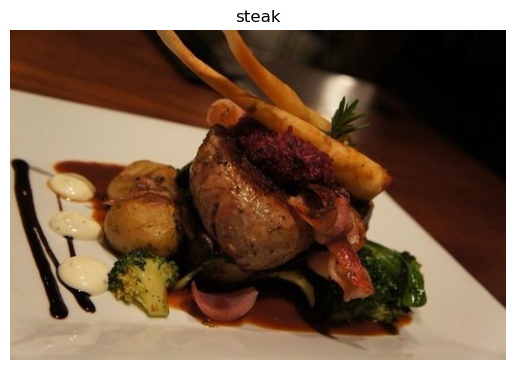

In [7]:
import random
import matplotlib.pyplot as plt

def view_random_image(target_dir, target_class):
    """
    Plots a random image from target directory with target class.
    """
    target_folder = target_dir / target_class
    
    random_image = random.sample(os.listdir(target_folder), 1)
    
    img = plt.imread(target_folder / random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    
    print(f"Image shape: {img.shape}") # show the shape of the image
    
    return img

img = view_random_image(train_dir, random.choice(class_names))


### Image Encoding and Normalization

In [8]:
import numpy as np
import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
# use PIL to resize all images to 224x224


def process_images(dir_path):
    X = []
    y = []
    for category in class_names:
        for image in os.listdir(dir_path / category):
            img = Image.open(dir_path / category / image)
            img = img.resize((224,224))
            X.append(np.array(img).flatten())
            y.append(class_to_idx[category])

    return X, y

X_train, y_train = process_images(train_dir)
X_test, y_test = process_images(test_dir)
X_pred, y_pred = process_images(pred_dir)


# shuffle the data

def shuffle_data(X, y):
    data = list(zip(X, y))
    random.shuffle(data)
    X, y = zip(*data)
    return X, np.array(y)

X_train, y_train = shuffle_data(X_train, y_train)
X_test, y_test = shuffle_data(X_test, y_test)
X_pred, y_pred = shuffle_data(X_pred, y_pred)

# scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_pred = scaler.transform(X_pred)



### Model 1: Random Forest

In [9]:
# import random forest classifier
from sklearn.ensemble import RandomForestClassifier

k = 10
kf = KFold(n_splits=k, shuffle=True)

accuracies = []
f1_scores = []
precisions = []
recalls = []
model1 = RandomForestClassifier()

for train_index, test_index in kf.split(X_train, y_train):
    X_trn, X_tst = X_train[train_index], X_train[test_index]
    y_trn, y_tst = y_train[train_index], y_train[test_index]
    model1.fit(X_trn, y_trn)
    accuracies.append(metrics.accuracy_score(y_tst, model1.predict(X_tst)))
    f1_scores.append(metrics.f1_score(y_tst, model1.predict(X_tst), average='weighted'))
    precisions.append(metrics.precision_score(y_tst, model1.predict(X_tst), average='weighted'))
    recalls.append(metrics.recall_score(y_tst, model1.predict(X_tst), average='weighted'))

model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)



In [10]:
accuracy1 = sum(accuracies)/k;
precision1 = sum(precisions)/k;
recall1 = sum(recalls)/k;
f11 = sum(f1_scores)/k;

print("Random Forest Classifier")
print(f"Accuracy: {round(accuracy1*100, 2)}%")
print(f"Precision: {round(precision1*100, 2)}%")
print(f"Recall: {round(recall1*100, 2)}%")
print(f"F1 Score: {round(f11*100, 2)}%")


Random Forest Classifier
Accuracy: 61.69%
Precision: 63.73%
Recall: 61.69%
F1 Score: 61.61%


In [11]:
# make predictions on prediction images using random forest classifier
print("Random Forest Classifier Predictions on " + str(len(X_pred)) + " prediction images")
for i in range(len(X_pred)):
    prediction = model1.predict([X_pred[i]])
    print("Prediction:", idx_to_class[prediction[0]], "======", "Actual:", idx_to_class[y_pred[i]])


Random Forest Classifier Predictions on 45 prediction images
Prediction: steak ====== Actual: steak
Prediction: steak ====== Actual: steak
Prediction: sushi ====== Actual: sushi
Prediction: sushi ====== Actual: steak
Prediction: steak ====== Actual: sushi
Prediction: sushi ====== Actual: pizza
Prediction: sushi ====== Actual: pizza
Prediction: pizza ====== Actual: pizza
Prediction: steak ====== Actual: steak
Prediction: pizza ====== Actual: sushi
Prediction: sushi ====== Actual: sushi
Prediction: pizza ====== Actual: sushi
Prediction: pizza ====== Actual: pizza
Prediction: sushi ====== Actual: pizza
Prediction: sushi ====== Actual: pizza
Prediction: pizza ====== Actual: pizza
Prediction: sushi ====== Actual: sushi
Prediction: steak ====== Actual: pizza
Prediction: steak ====== Actual: steak
Prediction: sushi ====== Actual: steak
Prediction: sushi ====== Actual: sushi
Prediction: steak ====== Actual: sushi
Prediction: pizza ====== Actual: pizza
Prediction: sushi ====== Actual: steak
Pre

### Performing Feature Selection and Retraining Model 1

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=25, whiten=True)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_pred_pca = pca.transform(X_pred)


In [28]:

model2 = RandomForestClassifier()

accuracies = []
f1_scores = []
precisions = []
recalls = []


for train_index, test_index in kf.split(X_train_pca, y_train):
    X_trn, X_tst = X_train_pca[train_index], X_train_pca[test_index]
    y_trn, y_tst = y_train[train_index], y_train[test_index]
    model2.fit(X_trn, y_trn)
    accuracies.append(metrics.accuracy_score(y_tst, model2.predict(X_tst)))
    f1_scores.append(metrics.f1_score(y_tst, model2.predict(X_tst), average='weighted'))
    precisions.append(metrics.precision_score(y_tst, model2.predict(X_tst), average='weighted'))
    recalls.append(metrics.recall_score(y_tst, model2.predict(X_tst), average='weighted'))

accuracyFeature1 = sum(accuracies)/k;
precisionFeature1 = sum(precisions)/k;
recallFeature1 = sum(recalls)/k;
f1Feature1 = sum(f1_scores)/k;

print("Random Forest Classifier with PCA")
print(f"Accuracy: {round(accuracyFeature1*100, 2)}%")
print(f"Average Precision: {round(precisionFeature1*100, 2)}%")
print(f"Average Recall: {round(recallFeature1*100, 2)}%")
print(f"Average F1 Score: {round(f1Feature1*100, 2)}%")
print("____________________________________________________")

print('\n')


# make predictions on prediction images using random forest classifier with PCA
print("Random Forest Classifier with PCA Predictions on " + str(len(X_pred)) + " prediction images")
for i in range(len(X_pred)):
    prediction = model2.predict([X_pred_pca[i]])
    print("Prediction:", idx_to_class[prediction[0]], "======", "Actual:", idx_to_class[y_pred[i]])
    

Random Forest Classifier with PCA
Accuracy: 60.6%
Average Precision: 62.64%
Average Recall: 60.6%
Average F1 Score: 60.61%
____________________________________________________


Random Forest Classifier with PCA Predictions on 45 prediction images
Prediction: steak ====== Actual: steak
Prediction: steak ====== Actual: steak
Prediction: sushi ====== Actual: sushi
Prediction: sushi ====== Actual: steak
Prediction: sushi ====== Actual: sushi
Prediction: sushi ====== Actual: pizza
Prediction: pizza ====== Actual: pizza
Prediction: pizza ====== Actual: pizza
Prediction: steak ====== Actual: steak
Prediction: pizza ====== Actual: sushi
Prediction: pizza ====== Actual: sushi
Prediction: sushi ====== Actual: sushi
Prediction: steak ====== Actual: pizza
Prediction: sushi ====== Actual: pizza
Prediction: sushi ====== Actual: pizza
Prediction: pizza ====== Actual: pizza
Prediction: sushi ====== Actual: sushi
Prediction: pizza ====== Actual: pizza
Prediction: steak ====== Actual: steak
Prediction:

### Model 2: Artificial Neural Network

In [30]:
accuracies = []
f1_scores = []
precisions = []
recalls = []
model2 = MLPClassifier(hidden_layer_sizes=(50,50,50), max_iter=500, random_state=42)

for train_index, test_index in kf.split(X_train, y_train):
    X_trn, X_tst = X_train[train_index], X_train[test_index]
    y_trn, y_tst = y_train[train_index], y_train[test_index]
    model2.fit(X_trn, y_trn)
    accuracies.append(metrics.accuracy_score(y_tst, model2.predict(X_tst)))
    f1_scores.append(metrics.f1_score(y_tst, model2.predict(X_tst), average='weighted'))
    precisions.append(metrics.precision_score(y_tst, model2.predict(X_tst), average='weighted'))
    recalls.append(metrics.recall_score(y_tst, model2.predict(X_tst), average='weighted'))
    
y_pred2 = model2.predict(X_test)


In [31]:
# Evaluate the model
accuracy2 = sum(accuracies)/k;
precision2 = sum(precisions)/k;
recall2 = sum(recalls)/k;
f12 = sum(f1_scores)/k;

print("Artificial Neural Network")
print(f"Accuracy: {round(accuracy2*100, 2)}%")
print(f"Average Precision: {round(precision2*100, 2)}%")
print(f"Average Recall: {round(recall2*100, 2)}%")
print(f"Average F1 Score: {round(f12*100, 2)}%")

Artificial Neural Network
Accuracy: 52.37%
Average Precision: 54.1%
Average Recall: 52.37%
Average F1 Score: 51.67%


In [32]:
# make predictions on prediction images using artificial neural network
print("Artificial Neural Network Predictions on " + str(len(X_pred)) + " prediction images")
for i in range(len(X_pred)):
    prediction = model2.predict([X_pred[i]])
    print("Prediction:", idx_to_class[prediction[0]], "======", "Actual:", idx_to_class[y_pred[i]])

Artificial Neural Network Predictions on 45 prediction images
Prediction: steak ====== Actual: steak
Prediction: steak ====== Actual: steak
Prediction: sushi ====== Actual: sushi
Prediction: pizza ====== Actual: steak
Prediction: pizza ====== Actual: sushi
Prediction: sushi ====== Actual: pizza
Prediction: sushi ====== Actual: pizza
Prediction: pizza ====== Actual: pizza
Prediction: steak ====== Actual: steak
Prediction: sushi ====== Actual: sushi
Prediction: pizza ====== Actual: sushi
Prediction: pizza ====== Actual: sushi
Prediction: steak ====== Actual: pizza
Prediction: sushi ====== Actual: pizza
Prediction: sushi ====== Actual: pizza
Prediction: sushi ====== Actual: pizza
Prediction: sushi ====== Actual: sushi
Prediction: steak ====== Actual: pizza
Prediction: steak ====== Actual: steak
Prediction: sushi ====== Actual: steak
Prediction: sushi ====== Actual: sushi
Prediction: steak ====== Actual: sushi
Prediction: pizza ====== Actual: pizza
Prediction: sushi ====== Actual: steak
Pr

### Performing Feature Selection with Principal Component Analysis (PCA) and Retraining Model 2


In [33]:

ann2 = MLPClassifier(hidden_layer_sizes=(50,50,50), max_iter=500, random_state=42)

accuracies = []
f1_scores = []
precisions = []
recalls = []

for train_index, test_index in kf.split(X_train_pca, y_train):
    X_trn, X_tst = X_train_pca[train_index], X_train_pca[test_index]
    y_trn, y_tst = y_train[train_index], y_train[test_index]
    ann2.fit(X_trn, y_trn)
    accuracies.append(metrics.accuracy_score(y_tst, ann2.predict(X_tst)))
    f1_scores.append(metrics.f1_score(y_tst, ann2.predict(X_tst), average='weighted'))
    precisions.append(metrics.precision_score(y_tst, ann2.predict(X_tst), average='weighted'))
    recalls.append(metrics.recall_score(y_tst, ann2.predict(X_tst), average='weighted'))

accuracyFeature = sum(accuracies)/k;
precisionFeature = sum(precisions)/k;
recallFeature = sum(recalls)/k;
f1Feature = sum(f1_scores)/k;

print("Artificial Neural Network with PCA")
print(f"Accuracy: {round(accuracyFeature*100, 2)}%")
print(f"Average Precision: {round(precisionFeature*100, 2)}%")
print(f"Average Recall: {round(recallFeature*100, 2)}%")
print(f"Average F1 Score: {round(f1Feature*100, 2)}%")
print("____________________________________________________")
print('\n')

# make predictions on prediction images using artificial neural network with PCA
print("Artificial Neural Network with PCA Predictions on " + str(len(X_pred)) + " prediction images")

for i in range(len(X_pred)):
    prediction = ann2.predict([X_pred_pca[i]])
    print("Prediction:", idx_to_class[prediction[0]], "======", "Actual:", idx_to_class[y_pred[i]])
    

Artificial Neural Network with PCA
Accuracy: 50.78%
Average Precision: 52.37%
Average Recall: 50.78%
Average F1 Score: 50.5%
____________________________________________________


Artificial Neural Network with PCA Predictions on 45 prediction images
Prediction: steak ====== Actual: steak
Prediction: steak ====== Actual: steak
Prediction: pizza ====== Actual: sushi
Prediction: sushi ====== Actual: steak
Prediction: steak ====== Actual: sushi
Prediction: sushi ====== Actual: pizza
Prediction: pizza ====== Actual: pizza
Prediction: pizza ====== Actual: pizza
Prediction: steak ====== Actual: steak
Prediction: pizza ====== Actual: sushi
Prediction: sushi ====== Actual: sushi
Prediction: sushi ====== Actual: sushi
Prediction: sushi ====== Actual: pizza
Prediction: pizza ====== Actual: pizza
Prediction: sushi ====== Actual: pizza
Prediction: sushi ====== Actual: pizza
Prediction: sushi ====== Actual: sushi
Prediction: sushi ====== Actual: pizza
Prediction: steak ====== Actual: steak
Predicti

### Model 3: Naive Bayes

In [34]:
# naive bayes classifier
from sklearn.naive_bayes import GaussianNB
accuracies = []
f1_scores = []
precisions = []
recalls = []
model3 = GaussianNB()

for train_index, test_index in kf.split(X_train, y_train):
    X_trn, X_tst = X_train[train_index], X_train[test_index]
    y_trn, y_tst = y_train[train_index], y_train[test_index]
    model3.fit(X_trn, y_trn)
    accuracies.append(metrics.accuracy_score(y_tst, model3.predict(X_tst)))
    f1_scores.append(metrics.f1_score(y_tst, model3.predict(X_tst), average='weighted'))
    precisions.append(metrics.precision_score(y_tst, model3.predict(X_tst), average='weighted'))
    recalls.append(metrics.recall_score(y_tst, model3.predict(X_tst), average='weighted'))
y_pred3 = model3.predict(X_test)


In [35]:
accuracy3 = sum(accuracies)/k;
precision3 = sum(precisions)/k;
recall3 = sum(recalls)/k;
f13 = sum(f1_scores)/k;

print("Naive Bayes Classifier")
print(f"Accuracy: {round(accuracy3*100, 2)}%")
print(f"Average Precision: {round(precision3*100, 2)}%")
print(f"Average Recall: {round(recall3*100, 2)}%")
print(f"Average F1 Score: {round(f13*100, 2)}%")

Naive Bayes Classifier
Accuracy: 61.91%
Average Precision: 64.03%
Average Recall: 61.91%
Average F1 Score: 61.79%


In [21]:
# make predictions on prediction images using naive bayes classifier
print("Naive Bayes Classifier Predictions on " + str(len(X_pred)) + " prediction images")
for i in range(len(X_pred)):
    prediction = model3.predict([X_pred[i]])
    print("Prediction:", idx_to_class[prediction[0]], "======", "Actual:", idx_to_class[y_pred[i]])

Naive Bayes Classifier Predictions on 45 prediction images
Prediction: steak ====== Actual: steak
Prediction: steak ====== Actual: steak
Prediction: sushi ====== Actual: sushi
Prediction: sushi ====== Actual: steak
Prediction: steak ====== Actual: sushi
Prediction: sushi ====== Actual: pizza
Prediction: pizza ====== Actual: pizza
Prediction: pizza ====== Actual: pizza
Prediction: steak ====== Actual: steak
Prediction: pizza ====== Actual: sushi
Prediction: sushi ====== Actual: sushi
Prediction: pizza ====== Actual: sushi
Prediction: pizza ====== Actual: pizza
Prediction: sushi ====== Actual: pizza
Prediction: sushi ====== Actual: pizza
Prediction: pizza ====== Actual: pizza
Prediction: sushi ====== Actual: sushi
Prediction: sushi ====== Actual: pizza
Prediction: steak ====== Actual: steak
Prediction: sushi ====== Actual: steak
Prediction: sushi ====== Actual: sushi
Prediction: steak ====== Actual: sushi
Prediction: sushi ====== Actual: pizza
Prediction: sushi ====== Actual: steak
Predi

In [26]:
# naive bayes classifier with PCA
model3 = GaussianNB()
accuracies = []
f1_scores = []
precisions = []
recalls = []

for train_index, test_index in kf.split(X_train_pca, y_train):
    X_trn, X_tst = X_train_pca[train_index], X_train_pca[test_index]
    y_trn, y_tst = y_train[train_index], y_train[test_index]
    model3.fit(X_trn, y_trn)
    accuracies.append(metrics.accuracy_score(y_tst, model3.predict(X_tst)))
    f1_scores.append(metrics.f1_score(y_tst, model3.predict(X_tst), average='weighted'))
    precisions.append(metrics.precision_score(y_tst, model3.predict(X_tst), average='weighted'))
    recalls.append(metrics.recall_score(y_tst, model3.predict(X_tst), average='weighted'))

accuracyFeature3 = sum(accuracies)/k;
precisionFeature3 = sum(precisions)/k;
recallFeature3 = sum(recalls)/k;
f1Feature3 = sum(f1_scores)/k;

print("Naive Bayes Classifier with PCA")
print(f"Accuracy: {round(accuracyFeature3*100, 2)}%")
print(f"Average Precision: {round(precisionFeature3*100, 2)}%")
print(f"Average Recall: {round(recallFeature3*100, 2)}%")
print(f"Average F1 Score: {round(f1Feature3*100, 2)}%")
print("____________________________________________________")
print('\n')

# make predictions on prediction images using naive bayes classifier with PCA
print("Naive Bayes Classifier with PCA Predictions on " + str(len(X_pred)) + " prediction images")
for i in range(len(X_pred)):
    prediction = model3.predict([X_pred_pca[i]])
    print("Prediction:", idx_to_class[prediction[0]], "======", "Actual:", idx_to_class[y_pred[i]])
    

Naive Bayes Classifier with PCA
Accuracy: 58.21%
Average Precision: 63.26%
Average Recall: 58.21%
Average F1 Score: 58.51%
____________________________________________________


Naive Bayes Classifier with PCA Predictions on 45 prediction images
Prediction: steak ====== Actual: steak
Prediction: steak ====== Actual: steak
Prediction: steak ====== Actual: sushi
Prediction: sushi ====== Actual: steak
Prediction: sushi ====== Actual: sushi
Prediction: sushi ====== Actual: pizza
Prediction: pizza ====== Actual: pizza
Prediction: pizza ====== Actual: pizza
Prediction: pizza ====== Actual: steak
Prediction: pizza ====== Actual: sushi
Prediction: pizza ====== Actual: sushi
Prediction: pizza ====== Actual: sushi
Prediction: pizza ====== Actual: pizza
Prediction: sushi ====== Actual: pizza
Prediction: sushi ====== Actual: pizza
Prediction: pizza ====== Actual: pizza
Prediction: sushi ====== Actual: sushi
Prediction: pizza ====== Actual: pizza
Prediction: steak ====== Actual: steak
Prediction: s

Feature selection has improved the performance of the ANN, while it did not affect Random Forest much. However, it made the performance of Naive Bayes worse.


### Model 4: Convolutional Neural Network

CNNs can recognize the most important image features to produce more sophisticated classifiers.

### Processing images into tensors

In [109]:
from torchvision import datasets
import torch
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn


# define the transforms
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

# Turn image folders into Datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
pred_data = datasets.ImageFolder(pred_dir, transform=test_transforms)

# Turn datasets into DataLoaders
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)
pred_loader = DataLoader(pred_data, batch_size=10, shuffle=True)



In [110]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [66]:

num_classes = 3  # 3 classes: pizza, sushi, steak
learning_rate = 0.001
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model4 = SimpleCNN(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters(), lr=learning_rate)



for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model4(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 5.2048
Epoch [2/10], Loss: 1.5360
Epoch [3/10], Loss: 0.8172
Epoch [4/10], Loss: 1.0773
Epoch [5/10], Loss: 0.6556
Epoch [6/10], Loss: 1.1869
Epoch [7/10], Loss: 0.5619
Epoch [8/10], Loss: 1.2255
Epoch [9/10], Loss: 0.6202
Epoch [10/10], Loss: 0.5604


In [139]:
# Test the model
model4.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model4(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Test Accuracy of the model on the {total} test images: {100 * correct / total}% ")
    
# Actual VS. Predicted
model4.eval()

y_pred = []
y_true = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model4(images)
        _, predicted = torch.max(outputs.data, 1)
        
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(metrics.classification_report(y_true, y_pred, target_names=class_names))
    print('Confusion Matrix:')
    print(metrics.confusion_matrix(y_true, y_pred))


Test Accuracy of the model on the 162 test images: 62.96296296296296% 
Classification Report:
              precision    recall  f1-score   support

       pizza       0.61      0.74      0.67        54
       steak       0.74      0.80      0.77        54
       sushi       0.50      0.35      0.41        54

    accuracy                           0.63       162
   macro avg       0.62      0.63      0.62       162
weighted avg       0.62      0.63      0.62       162

Confusion Matrix:
[[40  1 13]
 [ 5 43  6]
 [21 14 19]]


In [153]:
# make predictions on prediction images using convolutional neural network
all_predictions = []
all_actual = []
print("Convolutional Neural Network Predictions on " + str(len(X_pred)) + " prediction images")
model4.eval()

with torch.no_grad():
    # print the real and predicted label for each prediction image
    for images, labels in pred_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model4(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_predictions.extend(predicted.tolist())
        all_actual.extend(labels.tolist())


for i in range(len(X_pred)):
    prediction = all_predictions[i]
    print("Prediction:", idx_to_class[prediction], "======", "Actual:", idx_to_class[all_actual[i]])

Convolutional Neural Network Predictions on 45 prediction images
Prediction: pizza ====== Actual: pizza
Prediction: steak ====== Actual: pizza
Prediction: pizza ====== Actual: sushi
Prediction: pizza ====== Actual: pizza
Prediction: sushi ====== Actual: sushi
Prediction: pizza ====== Actual: pizza
Prediction: pizza ====== Actual: pizza
Prediction: steak ====== Actual: steak
Prediction: steak ====== Actual: sushi
Prediction: pizza ====== Actual: pizza
Prediction: sushi ====== Actual: sushi
Prediction: pizza ====== Actual: pizza
Prediction: steak ====== Actual: steak
Prediction: pizza ====== Actual: pizza
Prediction: sushi ====== Actual: sushi
Prediction: sushi ====== Actual: sushi
Prediction: steak ====== Actual: steak
Prediction: sushi ====== Actual: pizza
Prediction: steak ====== Actual: sushi
Prediction: pizza ====== Actual: steak
Prediction: sushi ====== Actual: sushi
Prediction: pizza ====== Actual: pizza
Prediction: pizza ====== Actual: steak
Prediction: sushi ====== Actual: sushi